<a href="https://colab.research.google.com/github/camillebobsin/gbfs/blob/main/voronoi_diagram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [2]:
root = 'https://saopaulo.publicbikesystem.net/ube/gbfs/v1/'
endpoints = requests.get(root).json()['data']['en']['feeds']

In [4]:
main = endpoints[1]
main

{'name': 'station_information',
 'url': 'https://saopaulo-br.publicbikesystem.net/customer/ube/gbfs/v1/en/station_information'}

In [5]:
raw_station_information = requests.get(main['url']).json()['data']['stations']
station_information = pd.DataFrame(raw_station_information)
station_information.head(3)

,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,rental_methods,groups,obcn,nearby_distance,post_code,planned_date
0,1,1 - Largo da Batata,REGULAR,-23.566831,-46.693741,0.0,"Av. Brigadeiro Faria Lima, esquina R. Teodoro ...",83,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[Pinheiros],1,1000.0,NaN,NaN
1,3,3 - CPTM Pinheiros,VAULT,-23.566478,-46.701258,0.0,"R. Gilberto Sabino, 138/ ao lado do ponto de ô...",15,"[KEY, TRANSITCARD, PHONE]",[Pinheiros],3,1000.0,03164200,NaN
2,4,4 - Rua Diogo Moreira,REGULAR,-23.569145,-46.692003,0.0,"Av. Brigadeiro Faria Lima, na altura do número...",23,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[Pinheiros],4,1000.0,03164200,NaN


In [6]:
station_information['lng_lat'] = station_information[['lon', 'lat']].apply(tuple, axis=1)
station_information['geometry'] = station_information.lng_lat.apply(lambda p: Point(p))
station_information = gpd.GeoDataFrame(station_information)
station_information.head(3)

,station_id,name,physical_configuration,lat,lon,altitude,address,capacity,rental_methods,groups,obcn,nearby_distance,post_code,planned_date,lng_lat,geometry
0,1,1 - Largo da Batata,REGULAR,-23.566831,-46.693741,0.0,"Av. Brigadeiro Faria Lima, esquina R. Teodoro ...",83,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[Pinheiros],1,1000.0,NaN,NaN,"(-46.6937412022694, -23.5668309564147)",POINT (-46.69374 -23.56683)
1,3,3 - CPTM Pinheiros,VAULT,-23.566478,-46.701258,0.0,"R. Gilberto Sabino, 138/ ao lado do ponto de ô...",15,"[KEY, TRANSITCARD, PHONE]",[Pinheiros],3,1000.0,03164200,NaN,"(-46.7012582819428, -23.5664776214954)",POINT (-46.70126 -23.56648)
2,4,4 - Rua Diogo Moreira,REGULAR,-23.569145,-46.692003,0.0,"Av. Brigadeiro Faria Lima, na altura do número...",23,"[KEY, TRANSITCARD, CREDITCARD, PHONE]",[Pinheiros],4,1000.0,03164200,NaN,"(-46.6920025786078, -23.5691446194095)",POINT (-46.69200 -23.56914)


In [7]:
import geobr
import matplotlib.pyplot as plt

In [8]:
# Municipality of Sao Paulo
muni = geobr.read_municipality(code_muni=3550308, year=2020)
muni.head()

,code_muni,name_muni,code_state,abbrev_state,name_state,code_region,name_region,geometry
562,3550308.0,São Paulo,35.0,SP,São Paulo,3.0,Sudeste,"MULTIPOLYGON (((-46.54624 -23.35791, -46.54214..."


In [9]:
type(muni)

geopandas.geodataframe.GeoDataFrame

Text(0.5, 1.0, 'Municipality of São Paulo, 2020')

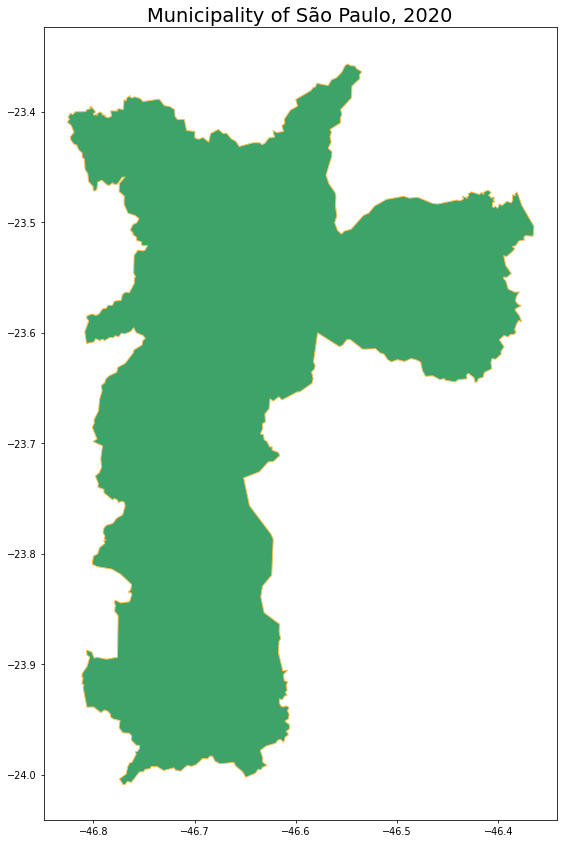

In [10]:
# Plot the data
fig, ax = plt.subplots(figsize=(15, 15), dpi=70)
muni.plot(facecolor="#3ea368", edgecolor="#FEBF57", ax=ax)
ax.set_title("Municipality of São Paulo, 2020", fontsize=20)

In [11]:
# Creating a MultiPolygon object
muni_multipoly = muni.iloc[0].geometry
type(muni_multipoly)

shapely.geometry.multipolygon.MultiPolygon

In [12]:
print(muni_multipoly.centroid)

POINT (-46.64815177560724 -23.65004381777975)


In [13]:
# Selects the coordinates of each bike rack
coords = []
for _, i in station_information.iterrows():
  lat = i['geometry'].x
  lon = i['geometry'].y
  coords.append([lat,lon])
type(coords)

list

In [14]:
import numpy as np

In [15]:
# Transforming coordinates into a numpy array of lists
arcoords = np.array(list(map(list, coords)))
type(arcoords)

numpy.ndarray

In [16]:
from geovoronoi import voronoi_regions_from_coords
import folium as f

In [17]:
# Voronoi function:
region_polys, region_pts = voronoi_regions_from_coords(arcoords, muni_multipoly)

In [18]:
def newMap():
    return f.Map(location=[-23.549279718284097, -46.63297420696871], zoom_start=12, tiles="cartodbpositron")

In [19]:
# Adding voronoi polygons on the map
m = newMap()

for count, r in enumerate(region_polys.values()):
  geo_j = f.GeoJson(data=r, style_function=lambda x: {'fillColor': 'lightblue', 'color' : 'gray'})
  geo_j.add_to(m)
m

In [20]:
# Adding bikes racks on the map
for i in coords:
  f.Circle(radius=15, location=[i[1], i[0]], color = 'blue', fill=True).add_to(m)
m

In [21]:
m.save('VoronoiMap.html')

In [22]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [23]:
vor = Voronoi(coords, qhull_options='Qbb Qc Qx')
type(vor)

scipy.spatial.qhull.Voronoi

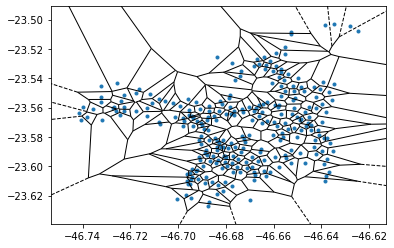

In [24]:
# Static view
fig = voronoi_plot_2d(vor, show_vertices=False)
plt.show()

In [25]:
# Grid geometry of each census sector
grid = gpd.read_file('setores_sp_metropolitano.shp')
grid.head(3)

,cod_setor,geometry
0,354780905000456,"POLYGON Z ((-46.51280 -23.63662 0.00000, -46.5..."
1,354780905000994,"POLYGON Z ((-46.53022 -23.68695 0.00000, -46.5..."
2,354780908000001,"POLYGON Z ((-46.49829 -23.64214 0.00000, -46.4..."


<AxesSubplot:>

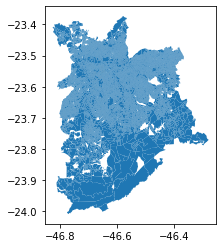

In [26]:
grid.plot()

In [27]:
# Dataframe with the information of the census sectors
df = pd.read_csv("Basico_SP1.csv", sep=';', encoding='ISO-8859-1')
df.rename(columns = {'Cod_setor' : 'cod_setor'}, inplace = True)
df.head(3)

,cod_setor,Cod_Grandes Regiões,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,Cod_RM,...,V004,V005,V006,V007,V008,V009,V010,V011,V012,Unnamed: 33
0,355030801000001,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,"2,32","2091,32","8532451,78","2164,55","8673276,78","1227,41","4285771,99","1713,75","5152087,86",NaN
1,355030801000002,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,"2,09","1650,09","3983441,31","1717,44","4030519,99","1045,78","2572133,32","1468,08","2991546,94",NaN
2,355030801000003,3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,20,...,"3,08","1280,43","5474593,06","2349,53","7553913,02","902,97","2735492,52","1786,79","3837674,74",NaN


In [28]:
grid['cod_setor'] = grid['cod_setor'].astype(int)
type(grid.cod_setor)

pandas.core.series.Series

In [29]:
df['cod_setor'] = df['cod_setor'].astype(int)
type(df.cod_setor)

pandas.core.series.Series

In [30]:
# Merging the grid with the df
sector_grid = grid.merge(df, on="cod_setor")
sector_grid.head(2)

,cod_setor,geometry,Cod_Grandes Regiões,Nome_Grande_Regiao,Cod_UF,Nome_da_UF,Cod_meso,Nome_da_meso,Cod_micro,Nome_da_micro,...,V004,V005,V006,V007,V008,V009,V010,V011,V012,Unnamed: 33
0,355030803000008,"POLYGON Z ((-46.78972 -23.43804 0.00000, -46.7...",3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,...,"4,2","1073,9","1610459,64","1348,51","1652150,28","613,36","831836,5","1088,88","959210,97",NaN
1,355030817000212,"POLYGON Z ((-46.76929 -23.65328 0.00000, -46.7...",3,Região Sudeste,35,São Paulo,3515,Metropolitana de São Paulo,35061,São Paulo,...,"1,3","4036,6","11094835,74","4714,5","9751864,94","2117,16","8082895,06","3812,6","8091758,92",NaN


<AxesSubplot:>

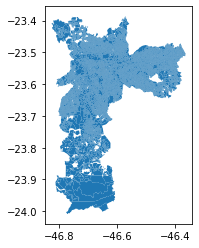

In [31]:
sector_grid.plot()

In [32]:
# Turning voronoi region dictionary into a dataframe
vor_polys_df = pd.DataFrame(list(region_polys.items()))
vor_polys_df.rename(columns = {0 : 'poly_id', 1: 'geometry'}, inplace = True)
vor_polys_df.head()

,poly_id,geometry
0,0,POLYGON ((-46.760083864214835 -23.553328098399...
1,1,POLYGON ((-46.64163103160026 -23.4275375922345...
2,2,POLYGON ((-46.61907202863609 -23.4183023192905...
3,3,POLYGON ((-46.637352976705934 -23.521629847913...
4,4,POLYGON ((-46.69000283826099 -23.6172730137699...


In [33]:
# Transforming dataframe into geodataframe
voronoi_polys = gpd.GeoDataFrame(vor_polys_df, crs=4326)
voronoi_polys.head()

,poly_id,geometry
0,0,"POLYGON ((-46.76008 -23.55333, -46.75999 -23.5..."
1,1,"POLYGON ((-46.64163 -23.42754, -46.63573 -23.4..."
2,2,"POLYGON ((-46.61907 -23.41830, -46.61261 -23.4..."
3,3,"POLYGON ((-46.63735 -23.52163, -46.64049 -23.5..."
4,4,"POLYGON ((-46.69000 -23.61727, -46.68719 -23.6..."


In [34]:
sector_grid = sector_grid.to_crs(4326)

In [40]:
# Spatial join of two GeoDataFrames
intersect = gpd.sjoin(voronoi_polys, sector_grid, how='inner').merge(sector_grid, on='cod_setor', suffixes=[None, '_sector']) 

In [ ]:
intersect['intersection_area'] = intersect.geometry_sector.intersection(intersect.geometry).area

intersect['sector_area'] = intersect.geometry_sector.area

In [42]:
intersect['intersection_factor'] = intersect['intersection_area'] / intersect['sector_area']

intersect['inhabitants'] = intersect['intersection_factor'] * intersect['V002']

In [43]:
population_per_poly = intersect.groupby('poly_id').agg({"inhabitants": "sum"})
population_per_poly.head(3)

,inhabitants
poly_id,
0,26388.722929
1,69109.386507
2,361337.014874


In [50]:
voron = voronoi_polys.merge(population_per_poly, on="poly_id")
voron['inhabitants'] = voron['inhabitants'].astype(int)
voron.head(3)

,poly_id,geometry,inhabitants
0,0,"POLYGON ((-46.76008 -23.55333, -46.75999 -23.5...",26388
1,1,"POLYGON ((-46.64163 -23.42754, -46.63573 -23.4...",69109
2,2,"POLYGON ((-46.61907 -23.41830, -46.61261 -23.4...",361337


In [65]:
# Map with the number of inhabitants of each region of voronoi
m1 = newMap()

for _, i in voron.iterrows():
  geo_json = f.GeoJson(data=i[1], style_function=lambda x: {'fillColor': 'lightblue', 'color' : 'gray'})
  popup = 'Poly id: {} \nPopulation: {}'.format(i[0], i[2]) # popup of each region
  f.Popup(popup).add_to(geo_json)
  geo_json.add_to(m1)

for i in coords:
  f.Circle(radius=15, location=[i[1], i[0]], color = 'blue', fill=True).add_to(m1)

m1

In [52]:
m1.save('InhabitantsByVoronoiMap.html')

In [ ]:
voron = voron.to_crs({'init': 'epsg:3857'})

In [63]:
# Area in km²
voron["area"] = voron['geometry'].area / 10**6

voron.head(2)

,poly_id,geometry,inhabitants,area
0,0,"POLYGON ((-5205308.725 -2699072.887, -5205298....",26388,3.633230
1,1,"POLYGON ((-5192122.616 -2683804.615, -5191465....",69109,14.879921


In [ ]:
voron = voron.to_crs({'init': 'epsg:4326'})

In [53]:
import branca.colormap as cm

In [66]:
linear = cm.linear.BuPu_07
linear

In [67]:
# Creating the ratio of inhabitants
max = voron.inhabitants.max()

voron['inhab_ratio'] = voron['inhabitants'] / max
voron.head(2)

,poly_id,geometry,inhabitants,area,inhab_ratio
0,0,"POLYGON ((-46.76008 -23.55333, -46.75999 -23.5...",26388,3.633230,0.009804
1,1,"POLYGON ((-46.64163 -23.42754, -46.63573 -23.4...",69109,14.879921,0.025676


In [69]:
m2 = newMap()

style_inhab = lambda x: {
    'fillColor': linear(x['properties']['inhab_ratio']),
    'color': 'black',
    'weight': 1.5,
    'fillOpacity': 0.7
}

f.GeoJson(voron, style_function=style_inhab).add_to(m2)

m2

In [70]:
m2.save('InhabRatioMap.html')

In [73]:
# Creating the area ratio
max = voron['area'].max()

voron['area_ratio'] = voron['area'] / max
voron.head(2)

,poly_id,geometry,inhabitants,area,inhab_ratio,area_ratio
0,0,"POLYGON ((-46.76008 -23.55333, -46.75999 -23.5...",26388,3.633230,0.009804,0.006661
1,1,"POLYGON ((-46.64163 -23.42754, -46.63573 -23.4...",69109,14.879921,0.025676,0.027279


In [74]:
m3 = newMap()

style_area = lambda x: {
    'fillColor': linear(x['properties']['area_ratio']),
    'color': 'black',
    'weight': 1.5,
    'fillOpacity': 0.7
}

f.GeoJson(voron, style_function=style_area).add_to(m3)

m3

In [75]:
m3.save('AreaRatioMap.html')

In [82]:
# Population density
voron['density'] = voron['inhabitants'] / voron['area']
voron['density'] = voron['density'].astype(int)
voron.head()

,poly_id,geometry,inhabitants,area,inhab_ratio,area_ratio,density,density_ratio
0,0,"POLYGON ((-46.76008 -23.55333, -46.75999 -23.5...",26388,3.633230,0.009804,0.006661,7262,0.183904
1,1,"POLYGON ((-46.64163 -23.42754, -46.63573 -23.4...",69109,14.879921,0.025676,0.027279,4644,0.117605
2,2,"POLYGON ((-46.61907 -23.41830, -46.61261 -23.4...",361337,81.888667,0.134246,0.150127,4412,0.111730
3,3,"POLYGON ((-46.63735 -23.52163, -46.64049 -23.5...",159403,23.868178,0.059222,0.043758,6678,0.169115
4,4,"POLYGON ((-46.69000 -23.61727, -46.68719 -23.6...",3839,0.670831,0.001426,0.001230,5722,0.144905


In [78]:
# Creating the density ratio
max = voron['density'].max()

voron['density_ratio'] = voron['density'] / max
voron.head(2)

,poly_id,geometry,inhabitants,area,inhab_ratio,area_ratio,density,density_ratio
0,0,"POLYGON ((-46.76008 -23.55333, -46.75999 -23.5...",26388,3.633230,0.009804,0.006661,7262,0.183904
1,1,"POLYGON ((-46.64163 -23.42754, -46.63573 -23.4...",69109,14.879921,0.025676,0.027279,4644,0.117605


In [79]:
m4 = newMap()

style_density = lambda x: {
    'fillColor': linear(x['properties']['density_ratio']),
    'color': 'black',
    'weight': 1.5,
    'fillOpacity': 0.7
}

f.GeoJson(voron, style_function=style_density).add_to(m4)

m4

In [80]:
m4.save('DensityRatioMap.html')